# This Jupyter Notebook trains a Hybrid Neural Network to predict the fatigue life of metal specimens based on the strain loading path, material type, and material properties.

##First, we import the cleaned and processed raw data, and ready it for training.

### We import the final_data file we created in the Data_Cleaning_Processing Jupyter Notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import pandas as pd

csv_path = '/content/drive/MyDrive/MANE4962_FinalProject_RawData/final_data.csv'

df_full_state = pd.read_csv(csv_path, index_col=0)

df_full_state.head()

,linear_strain_t1,linear_strain_t2,linear_strain_t3,linear_strain_t4,linear_strain_t5,linear_strain_t6,linear_strain_t7,linear_strain_t8,linear_strain_t9,linear_strain_t10,...,torsional_strain_t238,torsional_strain_t239,torsional_strain_t240,torsional_strain_t241,Elastic Modulus [GPA],Ultimate Tensile Strength [MPA],Yield Strength [MPA],Poissons Ratio,Material,Nf(label)
filename,,,,,,,,,,,,,,,,,,,,,
HRB335-0.002.csv,0.0,0.000033,0.000067,0.000100,0.000133,0.000167,0.000200,0.000233,0.000267,0.000300,...,0.000000,0.000000,0.000000,0.0000,210.00000,520.0,355.0,0.30,Carbon and Alloy Steel,4.482044
S460N-b-0.00104-0.0018.csv,0.0,0.000027,0.000054,0.000082,0.000109,0.000136,0.000163,0.000190,0.000216,0.000243,...,0.001794,0.001798,0.001799,0.0018,208.50000,643.0,500.0,0.30,Carbon and Alloy Steel,5.759366
E235-0.0021-0.0037.csv,0.0,0.000055,0.000110,0.000165,0.000220,0.000274,0.000329,0.000383,0.000437,0.000490,...,-0.000290,-0.000194,-0.000097,0.0000,196.40000,375.4,247.8,0.30,Carbon and Alloy Steel,4.254500
E355-2-8-0.0037-0.0063.csv,0.0,0.000097,0.000194,0.000290,0.000387,0.000483,0.000579,0.000674,0.000769,0.000864,...,-0.001947,-0.001310,-0.000659,0.0000,208.60000,473.0,318.4,0.29,Carbon and Alloy Steel,2.985875
Haynes188-760-A-0.00416.csv,0.0,0.000069,0.000139,0.000208,0.000277,0.000347,0.000416,0.000485,0.000555,0.000624,...,0.000000,0.000000,0.000000,0.0000,146.93456,490.0,268.0,0.50,NaN,4.545381


### To train our model, we process our data by reshaping the time series (strain loading) features for a GRU input. The material property features are normalized. The material categorical feature is turned into one-hot encoded

In [33]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = df_full_state.to_numpy()
X = data[:, :-1]  #Feature Data
y = data[:, -1]   #Target Data

X_linear = X[:, :241]       #First 241 columns (linear strain)
X_torsional = X[:, 241:482] #Next 241 columns (torsional strain)

#Reshaping for GRU, need to feed in both linear and torsional
X_time_series = np.stack([X_linear, X_torsional], axis=-1)  #Shape: (observations, 241, 2)
print(X_time_series.shape)

#4 Continuous features
X_continuous = X[:, 482:486]

#Categorical feature (1 column) with some NaN values
X_categorical = pd.DataFrame(X[:, 486], columns=["Category"])
#This makes sure empty strings are treated as NaN
X_categorical.replace('', np.nan, inplace=True)

#One-hot encodes categorical feature
X_categorical_encoded = pd.get_dummies(X_categorical["Category"], dummy_na=False)

#Any remaining NaN values are set to 0, giving zero vectors for the categorical one-hot vector
X_categorical_final = X_categorical_encoded.fillna(0)

#Normalize continuous features
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_continuous)

#Combines the continuous and categorical features back together
X_other = np.hstack([X_continuous_scaled, X_categorical_final.to_numpy()])

y = y.reshape(-1, 1)

#Train-test split
X_train_time, X_test_time, X_train_other, X_test_other, y_train, y_test = train_test_split(
    X_time_series, X_other, y, test_size=0.3, random_state=42
)

#Forces float types to avoid data type issues
X_train_other = X_train_other.astype(np.float32)
X_test_other = X_test_other.astype(np.float32)
X_train_time = X_train_time.astype(np.float32)
X_test_time = X_test_time.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

(914, 241, 2)


## With our data ready for training, the Hybrid Neural Network will constructed and trained.

### First, we define our model architecture. The time series features are fed into a deep GRU Neural Network. The remaining features are fed into a deep Artificial Neural Network. Both of these networks are then combined and fed into another deep neural network.

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import HeUniform, GlorotUniform, Orthogonal
from tensorflow.keras.layers import Flatten

#GRU-based sub-network (for time series)
input_time = Input(shape=(241, 2))  # Time series input
GRU_Branch = GRU(64, return_sequences=True, kernel_initializer=Orthogonal())(input_time)  # GRU layerGRU_Branch = Flatten()(GRU_output)
GRU_Branch = Flatten()(GRU_Branch)  # Flatten the output
GRU_Branch = Dense(64, activation="relu", kernel_initializer=HeUniform())(GRU_Branch)  # Dense layer
GRU_Branch = Dense(64, activation="relu", kernel_initializer=HeUniform())(GRU_Branch)  # Dense layer

#Dense sub-network (for continuous + categorical features)
input_other = Input(shape=(X_other.shape[1],))  # Other features input
Material_Branch = Dense(64, activation="relu", kernel_initializer=HeUniform())(input_other)  # Process categorical + continuous
Material_Branch = Dense(64, activation="relu", kernel_initializer=HeUniform())(Material_Branch)  # Process categorical + continuous
Material_Branch = Dense(64, activation="relu", kernel_initializer=HeUniform())(Material_Branch)  # Process categorical + continuous

#Combine both networks
combined = Concatenate()([GRU_Branch, Material_Branch])  # Merge GRU and Dense outputs
combined_layer = Dense(64, activation="relu", kernel_initializer=HeUniform())(combined)
combined_layer = Dense(64, activation="relu", kernel_initializer=HeUniform())(combined_layer)
final_layer = Dense(64, activation="relu", kernel_initializer=HeUniform())(combined_layer)
output = Dense(1)(final_layer)  # Regression output

# Define the full model
model = Model(inputs=[input_time, input_other], outputs=output)

The learning rate was chosen by manual hyperparameter tuning

In [35]:
optimizer = Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae", "mse"])

# Print model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 241, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 241, 64)   │     13,056 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 15424)     │          0 │ gru_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 64)        │        704 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 64)        │    987,200 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      4,160 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 64)        │      4,160 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 64)        │      4,160 │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ dense_37[0][0],   │
│ (Concatenate)       │                   │            │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │      8,256 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 64)        │      4,160 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │      4,160 │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 1)         │         65 │ dense_43[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,030,081 (3.93 MB)

 Trainable params: 1,030,081 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

### Now we train the model

In [36]:
# Save best model
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min")

# Train the model
history = model.fit(
    [X_train_time, X_train_other], y_train,  # Two inputs, ensure float32
    validation_data=([X_test_time, X_test_other], y_test),
    epochs=200,
    batch_size=16,
    callbacks=[checkpoint])

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 52.4305 - mae: 3.2878 - mse: 52.4305 - val_loss: 0.5750 - val_mae: 0.5914 - val_mse: 0.5750
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.7231 - mae: 0.6901 - mse: 0.7231 - val_loss: 0.8200 - val_mae: 0.7618 - val_mse: 0.8200
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7067 - mae: 0.6794 - mse: 0.7067 - val_loss: 0.7250 - val_mae: 0.7086 - val_mse: 0.7250
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6953 - mae: 0.6802 - mse: 0.6953 - val_loss: 1.2138 - val_mae: 0.9514 - val_mse: 1.2138
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8477 - mae: 0.7162 - mse: 0.8477 - val_loss: 1.1268 - val_mae: 0.8542 - val_mse: 1.1268
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6813 - mae: 0.6518 - mse: 0.6813 - val_loss: 0.5914 - val_mae: 0.5831 - val_mse: 0.5914
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5832 - mae: 0.6092 - mse: 0.5832 - v

In [37]:
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score

# Load the best model
best_model = load_model("best_model.keras")

X_test = [X_test_time, X_test_other] #X_test is a combo of the time data and the material data

# Get predictions
y_pred = best_model.predict(X_test)

# Evaluate loss & metrics
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f"Best Model Loss: {loss}, MAE: {mae}, MSE: {mse}")

# Calculate R^2 using tfa.metrics.RSquare
r2 = r2_score(y_test, y_pred)

print(f"Best Model R^2: {r2}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2911 - mae: 0.4158 - mse: 0.2911
Best Model Loss: 0.23871934413909912, MAE: 0.3817879259586334, MSE: 0.23871934413909912
Best Model R^2: 0.5883731842041016


## Results can now be plotted for ease of visualization

### Below are plots of expected vs actual fatigue life, and a set of tolerance bounds and heat map

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


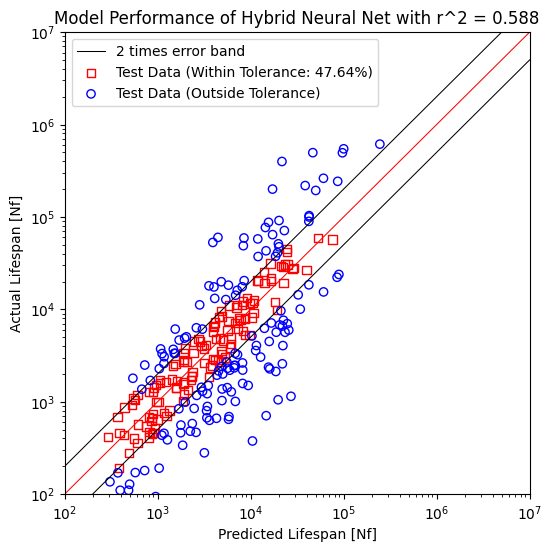

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Ensure y_pred and y_test contain numerical values
y_pred = best_model.predict(X_test).astype(float)  # Convert y_pred to float
y_test = y_test.astype(float)  # Convert y_test to float

# Calculate the difference between predictions and actual values in log space
diff = y_pred - y_test

# Find points within tolerance
tolerance = math.log10(2)  # Define your tolerance
within_tolerance = np.where(np.abs(diff) < tolerance)[0]
outside_tolerance = np.where(np.abs(diff) >= tolerance)[0]


# Calculate percentage within tolerance
percentage_within_tolerance = len(within_tolerance) / len(y_test) * 100

# Plot settings
plt.figure(figsize=(6, 6))

# Plot the y = x line (perfect predictions)
x_vals = np.logspace(2, 7, 100)
plt.plot(x_vals, x_vals, 'r-', linewidth=0.75, label="")

# Error bands
plt.plot(x_vals, 2 * x_vals, 'k-', linewidth=0.75, label="2 times error band")
plt.plot(x_vals, (1/2) * x_vals, 'k-', linewidth=0.75)

# Plot points within and outside tolerance with different markers
plt.scatter(10**y_pred[within_tolerance], 10**y_test[within_tolerance], marker='s', edgecolors='r', facecolors='none', label=f'Test Data (Within Tolerance: {percentage_within_tolerance:.2f}%)')
plt.scatter(10**y_pred[outside_tolerance], 10**y_test[outside_tolerance], marker='o', edgecolors='b', facecolors='none', label='Test Data (Outside Tolerance)')


# Log-log scale
plt.xscale("log")
plt.yscale("log")

plt.xlim(10**2, 10**7)
plt.ylim(10**2, 10**7)

# Labels and legend
plt.xlabel("Predicted Lifespan [Nf]")
plt.ylabel("Actual Lifespan [Nf]")
plt.legend()
#plt.grid(False, which="both", linestyle="--", linewidth=0.25)
plt.title(f'Model Performance of Hybrid Neural Net with r^2 = {r2:.3f}')

# Show plot
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


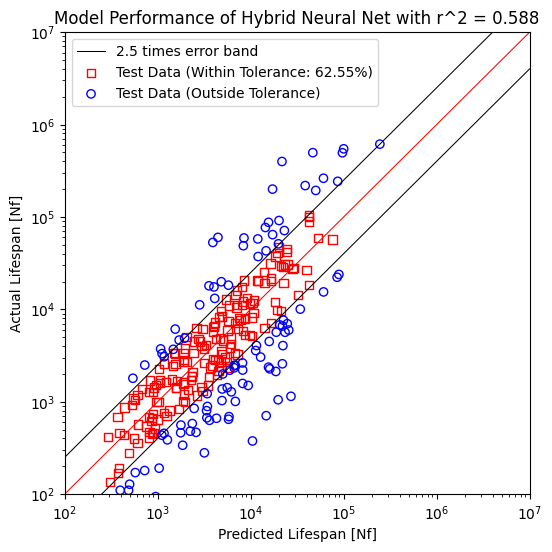

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Ensure y_pred and y_test contain numerical values
y_pred = best_model.predict(X_test).astype(float)  # Convert y_pred to float
y_test = y_test.astype(float)  # Convert y_test to float

# Calculate the difference between predictions and actual values in log space
diff = y_pred - y_test

# Find points within tolerance
tolerance = math.log10(2.5)  # Define your tolerance
within_tolerance = np.where(np.abs(diff) < tolerance)[0]
outside_tolerance = np.where(np.abs(diff) >= tolerance)[0]


# Calculate percentage within tolerance
percentage_within_tolerance = len(within_tolerance) / len(y_test) * 100

# Plot settings
plt.figure(figsize=(6, 6))

# Plot the y = x line (perfect predictions)
x_vals = np.logspace(2, 7, 100)
plt.plot(x_vals, x_vals, 'r-', linewidth=0.75, label="")

# Error bands
plt.plot(x_vals, 2.5 * x_vals, 'k-', linewidth=0.75, label="2.5 times error band")
plt.plot(x_vals, (1/2.5) * x_vals, 'k-', linewidth=0.75)

# Plot points within and outside tolerance with different markers
plt.scatter(10**y_pred[within_tolerance], 10**y_test[within_tolerance], marker='s', edgecolors='r', facecolors='none', label=f'Test Data (Within Tolerance: {percentage_within_tolerance:.2f}%)')
plt.scatter(10**y_pred[outside_tolerance], 10**y_test[outside_tolerance], marker='o', edgecolors='b', facecolors='none', label='Test Data (Outside Tolerance)')


# Log-log scale
plt.xscale("log")
plt.yscale("log")

plt.xlim(10**2, 10**7)
plt.ylim(10**2, 10**7)

# Labels and legend
plt.xlabel("Predicted Lifespan [Nf]")
plt.ylabel("Actual Lifespan [Nf]")
plt.legend()
#plt.grid(False, which="both", linestyle="--", linewidth=0.25)
plt.title(f'Model Performance of Hybrid Neural Net with r^2 = {r2:.3f}')

# Show plot
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


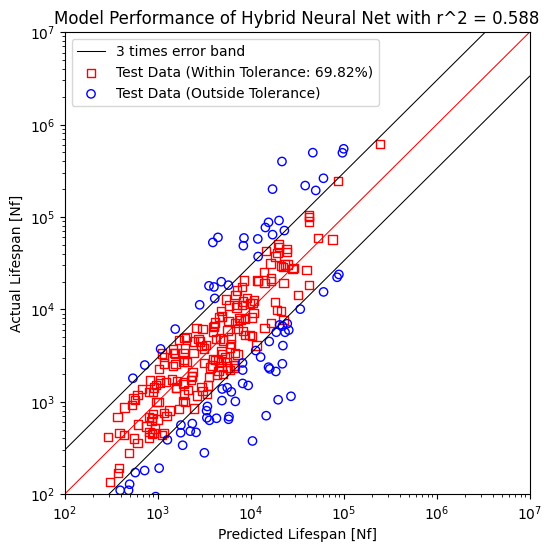

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Ensure y_pred and y_test contain numerical values
y_pred = best_model.predict(X_test).astype(float)  # Convert y_pred to float
y_test = y_test.astype(float)  # Convert y_test to float

# Calculate the difference between predictions and actual values in log space
diff = y_pred - y_test

# Find points within tolerance
tolerance = math.log10(3)  # Define your tolerance
within_tolerance = np.where(np.abs(diff) < tolerance)[0]
outside_tolerance = np.where(np.abs(diff) >= tolerance)[0]


# Calculate percentage within tolerance
percentage_within_tolerance = len(within_tolerance) / len(y_test) * 100

# Plot settings
plt.figure(figsize=(6, 6))

# Plot the y = x line (perfect predictions)
x_vals = np.logspace(2, 7, 100)
plt.plot(x_vals, x_vals, 'r-', linewidth=0.75, label="")

# Error bands
plt.plot(x_vals, 3 * x_vals, 'k-', linewidth=0.75, label="3 times error band")
plt.plot(x_vals, (1/3) * x_vals, 'k-', linewidth=0.75)

# Plot points within and outside tolerance with different markers
plt.scatter(10**y_pred[within_tolerance], 10**y_test[within_tolerance], marker='s', edgecolors='r', facecolors='none', label=f'Test Data (Within Tolerance: {percentage_within_tolerance:.2f}%)')
plt.scatter(10**y_pred[outside_tolerance], 10**y_test[outside_tolerance], marker='o', edgecolors='b', facecolors='none', label='Test Data (Outside Tolerance)')


# Log-log scale
plt.xscale("log")
plt.yscale("log")

plt.xlim(10**2, 10**7)
plt.ylim(10**2, 10**7)

# Labels and legend
plt.xlabel("Predicted Lifespan [Nf]")
plt.ylabel("Actual Lifespan [Nf]")
plt.legend()
#plt.grid(False, which="both", linestyle="--", linewidth=0.25)
plt.title(f'Model Performance of Hybrid Neural Net with r^2 = {r2:.3f}')

# Show plot
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


<ipython-input-47-5e1fb240e703>:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(10**y_pred[within_tolerance], 10**y_test[within_tolerance],


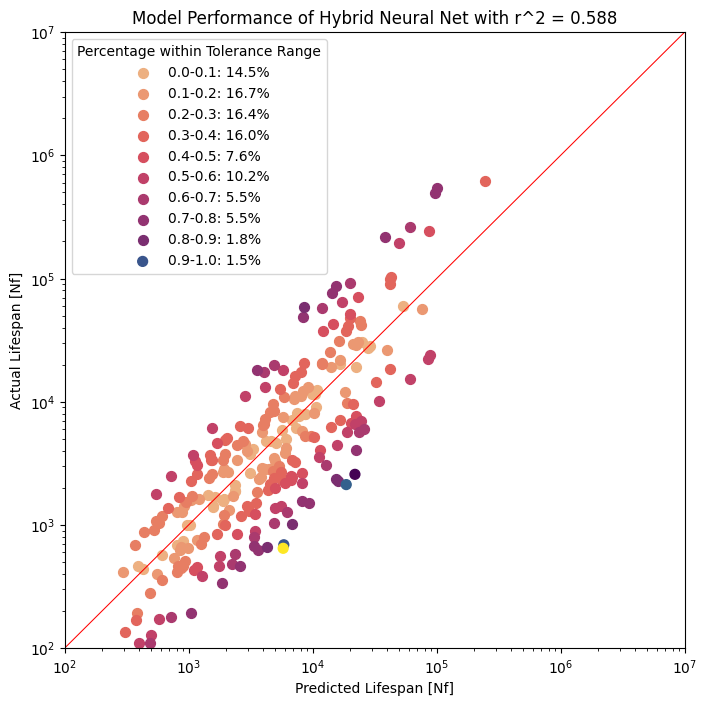

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure y_pred and y_test contain numerical values
y_pred = best_model.predict(X_test).astype(float)  # Convert y_pred to float
y_test = y_test.astype(float)  # Convert y_test to float

# Calculate the difference between predictions and actual values in log space
diff = y_pred - y_test

# Plot settings
plt.figure(figsize=(8, 8))

# Plot the y = x line (perfect predictions)
x_vals = np.logspace(2, 7, 100)
plt.plot(x_vals, x_vals, 'r-', linewidth=0.75, label="")

# Define colormap
cmap = sns.color_palette("flare", as_cmap=True)

# Iterate through tolerance ranges
for i in range(10):
    lower_bound = i * 0.1
    upper_bound = (i + 1) * 0.1

    within_tolerance = np.where((np.abs(diff) >= lower_bound) & (np.abs(diff) < upper_bound))[0]

    if len(within_tolerance) > 0 :
        percentage = len(within_tolerance) / len(y_test) * 100
        plt.scatter(10**y_pred[within_tolerance], 10**y_test[within_tolerance],
                    marker='o', s=50,  # Use circles
                    c=cmap(i/10), label=f'{lower_bound:.1f}-{upper_bound:.1f}: {percentage:.1f}%')

# Log-log scale
plt.xscale("log")
plt.yscale("log")

plt.xlim(10**2, 10**7)
plt.ylim(10**2, 10**7)

# Labels and legend
plt.xlabel("Predicted Lifespan [Nf]")
plt.ylabel("Actual Lifespan [Nf]")
plt.legend(title="Percentage within Tolerance Range")  # Add title to the legend
plt.title(f'Model Performance of Hybrid Neural Net with r^2 = {r2:.3f}')
plt.show()


### The last plots show the distribution of errors, to help visualize the deviation of errors from an expected normal distribution

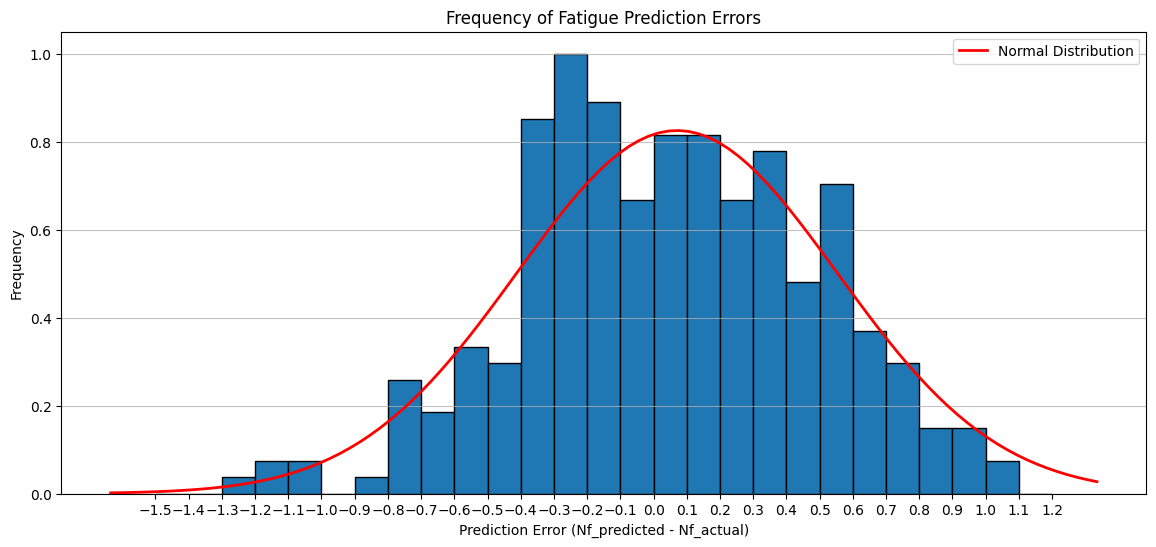

-1.6350000000000002 1.3350000000000026


In [49]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Create the histogram
plt.figure(figsize=(14, 6))

# Plot the histogram
plt.hist(diff, bins=np.arange(-1.5, 1.3, 0.1), edgecolor='black', density=True)

# Fit a normal distribution to the data
mu, std = norm.fit(diff)

# Generate x-values for the normal distribution curve
xmin, xmax = plt.xlim()
x_normal = np.linspace(xmin, xmax, 100)

# Calculate y-values for the normal distribution curve
y_normal = norm.pdf(x_normal, mu, std)

# Plot the normal distribution curve
plt.plot(x_normal, y_normal, color='red', linewidth=2, label="Normal Distribution")

# Customize the plot
plt.xlabel("Prediction Error (Nf_predicted - Nf_actual)")
plt.ylabel("Frequency")  # Or "Probability Density" if density=True
plt.title("Frequency of Fatigue Prediction Errors")
plt.xticks(np.arange(-1.5, 1.3, 0.1))  # Ensure ticks are aligned with bins
plt.grid(axis='y', alpha=0.75)
plt.legend()  # Add a legend

# Show the plot
plt.show()
print(xmin,xmax)

Probability within -0.5 to 0.5 (scaled PDF): 0.8601377180814055


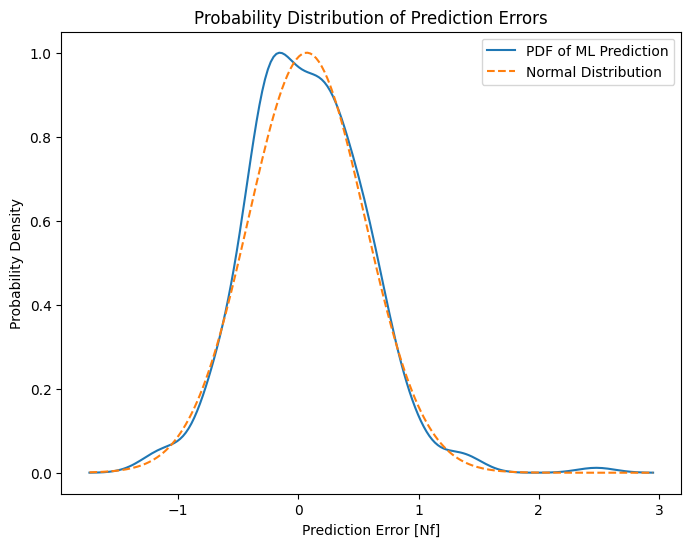

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import trapezoid
from scipy.stats import norm

# Calculate the difference between predictions and actual values
diff = y_pred - y_test

# Get KDE data without plotting
x, y = sns.kdeplot(diff.flatten(), gridsize=200).get_lines()[0].get_data()
# Close the KDE plot
plt.close()

# Normalize y-values to represent probabilities (sum to 1)
y_prob = y / trapezoid(y, x)  # Normalize using the total area

# Normalize the PDF to have a maximum value of 1 (scaling)
y_prob_scaled = y_prob / np.max(y_prob)

# Calculate mean and standard deviation of the prediction errors
mu, std = norm.fit(diff.flatten())

# Generate x-values for the normal distribution curve
x_normal = np.linspace(np.min(x), np.max(x), 200)

# Calculate y-values for the normal distribution curve
y_normal = norm.pdf(x_normal, mu, std)

# Normalize the normal distribution to the same scale as the scaled PDF
y_normal_scaled = y_normal / np.max(y_normal)

# Integrate within the range -0.5 to 0.5 (using the scaled PDF)
x_range = x[(x >= -0.5) & (x <= 0.5)]
y_range_scaled = y_prob_scaled[(x >= -0.5) & (x <= 0.5)]
probability_scaled = trapezoid(y_range_scaled, x_range)

print(f"Probability within -0.5 to 0.5 (scaled PDF): {probability_scaled}")

# Plot the scaled PDF and the normal distribution
plt.figure(figsize=(8, 6))
plt.plot(x, y_prob_scaled, label="PDF of ML Prediction")
plt.plot(x_normal, y_normal_scaled, label="Normal Distribution", linestyle='--')

plt.xlabel("Prediction Error [Nf]")
plt.ylabel("Probability Density")
plt.title("Probability Distribution of Prediction Errors")
plt.legend()
plt.show()